|Traitement|Scratch|VGG16|InceptionV3|Xception 
|-----|:-------:|:------:|:------:|:------ :
|Base|
|Avec Data Augmentation|
|Avec Data Augmentation et FineTuning|

# 1. Initialisation

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
plt.style.use("default")

from sklearn.model_selection import train_test_split

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications import VGG16
from keras.applications import InceptionV3

In [13]:
# Création des fonctions

def get_dataframe(path, n_breeds=12):
    dogs_lst = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            dogs_lst.append(os.path.join(dirname, filename))

    # Je stocke dans un dataframe
    dogs_raw = pd.DataFrame(dogs_lst, columns=['uri'])

    # J'extrais la race
    dogs_raw['breeds'] = dogs_raw.uri.str.split('/').str.get(5).str.slice(10)
    
    # Délimitation du nombre de race
    top_breeds = dogs_raw.groupby('breeds').count().sort_values(by='uri', ascending=False).head(n_breeds).reset_index().breeds.to_list()
    dogs = pd.DataFrame()
    for b in top_breeds:
        dogs = dogs.append(dogs_raw[dogs_raw.breeds == b])

    return dogs


def get_batch_size(gen):
    lst = []
    dict = {}
    
    # Test des nombres entiers et intégration dans un dictionnaire
    for i in range(1,40):
        dict[i] = gen % i
    
    # Récupération du plus grand nombre entiers
    for key, value in dict.items():
        if value == 0:
            lst.append(key)

    return max(lst)


def get_model(act_function):
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(256, activation=act_function))
    model.add(Dense(len(train_gen.class_indices), activation='softmax'))
    return model


def plot_activation_functions(history, subtitle):
    # Extraction des historique
    val_loss = {k:v.history['val_loss'] for k,v in activation_results.items()}
    val_acc = {k:v.history['val_accuracy'] for k,v in activation_results.items()}
    # Conversion en df
    val_loss_curves = pd.DataFrame(val_loss_per_funct)
    val_acc_curves = pd.DataFrame(val_acc)
    # Graphique
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    ax[0].plot(val_loss_curves.leaky_relu, label='leaky_relu')
    ax[0].plot(val_loss_curves.relu, label='relu')
    ax[0].plot(val_loss_curves.sigmoid, label='sigmoid')
    ax[0].plot(val_loss_curves.tanh, label='tanh')
    ax[0].set_title('val_loss | ' + subtitle)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Val_loss')
    ax[0].legend()

    ax[1].plot(val_acc_curves.leaky_relu, label='leaky_relu')
    ax[1].plot(val_acc_curves.relu, label='relu')
    ax[1].plot(val_acc_curves.sigmoid, label='sigmoid')
    ax[1].plot(val_acc_curves.tanh, label='tanh')
    ax[1].set_title('val_accuracy | ' + subtitle)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('val_accuracy')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_' + subtitle + '_activation_function.png',
                    transparent=True)
    return None


def plot_effect(history_std, history_modified, title, subtitle):
    # Conversion en dataframe
    df_model_std = pd.DataFrame(history_std.history['val_accuracy'], columns=["model_std"])
    df_model_modified = pd.DataFrame(history_modified.history['val_accuracy'], columns=[title])

    # Tracage
    pd.merge(df_model_std, df_model_modified, right_index=True, left_index=True).plot()
    plt.title(title + "_" + subtitle)
    plt.xlabel("epoch")
    plt.ylabel("val_accuracy")
    plt.savefig('./cnn_transfer_learning_ ' + subtitle + '_' + title + '.png',
                transparent=True)
    plt.show()
    return None


def plot_result_fitting(history, subtitle, n_breeds):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax[0].set_title('Accuracy | ' + subtitle + ' | ' + str(n_breeds) + ' breeds')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label = 'val_loss')
    ax[1].set_title('Loss function | ' + subtitle + ' | ' + str(n_breeds) + ' breeds')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_ ' + subtitle + '_' + str(n_breeds) + '_breeds_results.png',
                transparent=True)
    
    return None

# 2. Import des données et paramétrage
En phase exploratoire, je limite à 10% le nombre de races à tester (soit 12%)

In [3]:
n_breeds = 12
# Création du dataframe et sélection des 12 races les plus fournies en images
dogs = get_dataframe('../input/stanford-dogs-dataset/images', n_breeds)
print(f"Nous avons {dogs.breeds.nunique()} races sélectionnées pour la phase d'expérimentation.")
dogs

Nous avons 12 races sélectionnées pour la phase d'expérimentation.


,uri,breeds
8550,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
8551,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
8552,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
8553,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
8554,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
...,...,...
6688,../input/stanford-dogs-dataset/images/Images/n...,Tibetan_terrier
6689,../input/stanford-dogs-dataset/images/Images/n...,Tibetan_terrier
6690,../input/stanford-dogs-dataset/images/Images/n...,Tibetan_terrier
6691,../input/stanford-dogs-dataset/images/Images/n...,Tibetan_terrier


In [4]:
# Séparation des données d'entrainements et de tests
train, test = train_test_split(dogs, test_size=0.2, random_state=42)

# Séparation des données d'entrainements et de validation
train, val = train_test_split(train, test_size=0.2, random_state=42)

Optimisation des générateurs :
* Pour des raisons d'économies de calcul, je réduis toutes les images à 150*150 pixels,
* Il est important que batch_size soit un nombre entier du jeu de test. Si ce n'est pas le cas du jeu d'entrainement et du jeu de validation, ce n'est pas bien grave car l'image sera retraitée dans une autre epoch,
* shuffle sera égal à True sur les jeu d'entraînement et de validation, et sera égal à False sur le jeu de test. Cela me permettra de faire correspondre les prédictions en sortie avec les identifiants.
* L'augmentation des données ne se fera que sur les données d'entraînements. Cela consiste à modifier une image de manière aléatoire (rotation, zoom, mirroir) de manière à ce que l'algorithmes ne voit qu'une fois la même image.


In [5]:
### Paramétrage
x = 'uri'
y = 'breeds'
target_size = (150, 150)
seed = 42

train_batch_size = get_batch_size(len(train))
val_batch_size = get_batch_size(len(val))
test_batch_size = get_batch_size(len(test))

train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Sans augmentation des données
train_gen = train_datagen.flow_from_dataframe(
                  train,
                  x_col='uri',
                  y_col='breeds',
                  target_size=target_size,
                  batch_size=train_batch_size,
                  seed=seed
                  )


# Avec augmentation des données
train_gen_data_aug = train_datagen_aug.flow_from_dataframe(
                          train,
                          x_col='uri',
                          y_col='breeds',
                          target_size=target_size,
                          batch_size=train_batch_size,
                          seed=seed
                          )

val_gen = val_test_datagen.flow_from_dataframe(
                  val,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=val_batch_size,
                  seed=seed
                  )

test_gen = val_test_datagen.flow_from_dataframe(
                  test,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=test_batch_size,
                  seed=seed,
                  shuffle=False
                  )

Found 1694 validated image filenames belonging to 12 classes.
Found 1694 validated image filenames belonging to 12 classes.
Found 424 validated image filenames belonging to 12 classes.
Found 530 validated image filenames belonging to 12 classes.


# 3. Evaluation du modèle VGG16
## 3.1 Paramétrage

In [6]:
### Paramétrage de la configuration

# Titre documents de sortie
subtitle = "VGG16"

# Choix du modèle convolutionnel de base, avec gel de la base
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
print('Nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))
conv_base.trainable = False
print('Nombre de poids entraînable après gel de la base convolutionnelle :', len(conv_base.trainable_weights))

58892288/58889256 [==============================] - 2s 0us/step
Nombre de poids entraînable avant gel de la base convolutionnelle : 26
Nombre de poids entraînable après gel de la base convolutionnelle : 0


## 3-2. Choix de la fonction d'activation de la couche dense avant classification

In [ ]:
activations = ['leaky_relu', 'relu', 'sigmoid' , 'tanh']
activation_results = {}

for funct in activations:
    print(f"Test de la fonction d'activation {funct} en cours ...")
    model = get_model(act_function=funct)
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(train_gen, validation_data=val_gen, epochs=20, verbose=0)
    activation_results[funct] = history

plot_activation_functions(history, subtitle)

## 3-3. Choix des ajustements
### 3-3-1. Formation du modèle standard comme point de comparaison

In [7]:
epochs = 40
verbose = 1

model_std = get_model(act_function='relu')
model_std.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

history_std = model_std.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose)

Epoch 1/40
77/77 [==============================] - 13s 165ms/step - loss: 2.0759 - accuracy: 0.3200 - val_loss: 1.6733 - val_accuracy: 0.4245
Epoch 2/40
77/77 [==============================] - 9s 116ms/step - loss: 1.1226 - accuracy: 0.6328 - val_loss: 1.7971 - val_accuracy: 0.4835
Epoch 3/40
77/77 [==============================] - 9s 121ms/step - loss: 0.7325 - accuracy: 0.7810 - val_loss: 1.7467 - val_accuracy: 0.4505
Epoch 4/40
77/77 [==============================] - 10s 128ms/step - loss: 0.4676 - accuracy: 0.8701 - val_loss: 1.4292 - val_accuracy: 0.5142
Epoch 5/40
77/77 [==============================] - 9s 117ms/step - loss: 0.2627 - accuracy: 0.9569 - val_loss: 1.5007 - val_accuracy: 0.4929
Epoch 6/40
77/77 [==============================] - 9s 123ms/step - loss: 0.1593 - accuracy: 0.9841 - val_loss: 1.5278 - val_accuracy: 0.4976
Epoch 7/40
77/77 [==============================] - 9s 117ms/step - loss: 0.0936 - accuracy: 0.9959 - val_loss: 1.5200 - val_accuracy: 0.5283
Epoc


### 3-3-2. Mesure de l'effet Data Augmentation

Epoch 1/40
77/77 [==============================] - 17s 227ms/step - loss: 2.2925 - accuracy: 0.2414 - val_loss: 1.9254 - val_accuracy: 0.3467
Epoch 2/40
77/77 [==============================] - 17s 227ms/step - loss: 1.8221 - accuracy: 0.3843 - val_loss: 1.6131 - val_accuracy: 0.4528
Epoch 3/40
77/77 [==============================] - 18s 232ms/step - loss: 1.5846 - accuracy: 0.4622 - val_loss: 1.6657 - val_accuracy: 0.4387
Epoch 4/40
77/77 [==============================] - 17s 220ms/step - loss: 1.5441 - accuracy: 0.4699 - val_loss: 1.5619 - val_accuracy: 0.4976
Epoch 5/40
77/77 [==============================] - 17s 225ms/step - loss: 1.4426 - accuracy: 0.4982 - val_loss: 1.4636 - val_accuracy: 0.5165
Epoch 6/40
77/77 [==============================] - 18s 235ms/step - loss: 1.3604 - accuracy: 0.5407 - val_loss: 1.4526 - val_accuracy: 0.4906
Epoch 7/40
77/77 [==============================] - 18s 229ms/step - loss: 1.3259 - accuracy: 0.5449 - val_loss: 1.4409 - val_accuracy: 0.5189

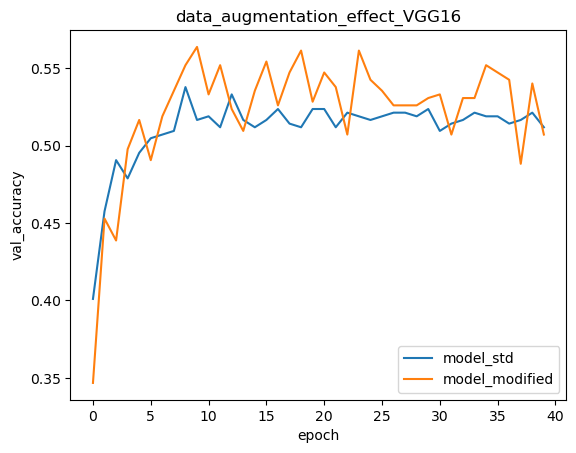

In [19]:
model_modified = get_model(act_function='relu')
model_modified.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history_modified = model_modified.fit(train_gen_data_aug, validation_data=val_gen, epochs=epochs, verbose=verbose)

title = "data_augmentation_effect"
plot_effect(history_std, history_modified, title, subtitle)

### 3-3-3. Mesure de l'effet Batch Normalization

Epoch 1/40
77/77 [==============================] - 9s 112ms/step - loss: 1.8758 - accuracy: 0.4132 - val_loss: 2.1868 - val_accuracy: 0.3774
Epoch 2/40
77/77 [==============================] - 8s 106ms/step - loss: 0.6441 - accuracy: 0.8170 - val_loss: 1.6757 - val_accuracy: 0.4788
Epoch 3/40
77/77 [==============================] - 9s 121ms/step - loss: 0.2827 - accuracy: 0.9351 - val_loss: 1.5839 - val_accuracy: 0.5047
Epoch 4/40
77/77 [==============================] - 9s 119ms/step - loss: 0.1364 - accuracy: 0.9740 - val_loss: 1.7633 - val_accuracy: 0.4906
Epoch 5/40
77/77 [==============================] - 8s 110ms/step - loss: 0.0544 - accuracy: 0.9953 - val_loss: 1.7499 - val_accuracy: 0.5071
Epoch 6/40
77/77 [==============================] - 8s 109ms/step - loss: 0.0311 - accuracy: 0.9982 - val_loss: 1.8101 - val_accuracy: 0.4835
Epoch 7/40
77/77 [==============================] - 8s 106ms/step - loss: 0.0199 - accuracy: 0.9988 - val_loss: 1.8562 - val_accuracy: 0.4811
Epoch 

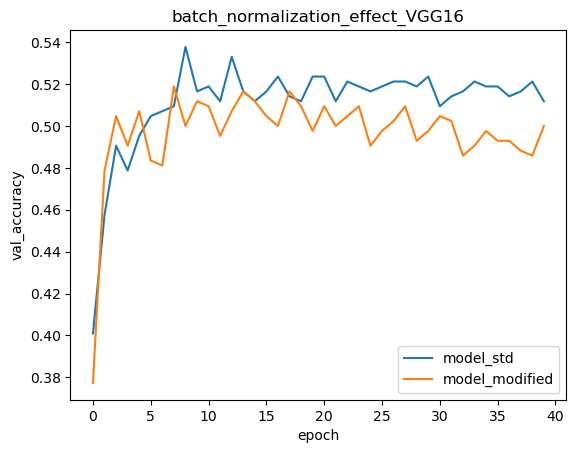

In [20]:
# Formation du modèle modifié
model_modified = Sequential()
model_modified.add(conv_base)
model_modified.add(Flatten())
model_modified.add(Dense(256, activation='relu'))
# Ajout de la couche de normalisation des batchs
model_modified.add(BatchNormalization())
model_modified.add(Dense(len(train_gen.class_indices), activation='softmax'))
model_modified.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

# Mesure des effets de la couche
history_modified = model_modified.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose)

title = "batch_normalization_effect"
plot_effect(history_std, history_modified, title, subtitle)

### 3-3-3. Mesure de l'effet Dropout

Epoch 1/40
77/77 [==============================] - 9s 116ms/step - loss: 2.1720 - accuracy: 0.2893 - val_loss: 1.7427 - val_accuracy: 0.4080
Epoch 2/40
77/77 [==============================] - 8s 108ms/step - loss: 1.3643 - accuracy: 0.5437 - val_loss: 1.5461 - val_accuracy: 0.4340
Epoch 3/40
77/77 [==============================] - 8s 106ms/step - loss: 0.8981 - accuracy: 0.7279 - val_loss: 1.4560 - val_accuracy: 0.4906
Epoch 4/40
77/77 [==============================] - 10s 126ms/step - loss: 0.6587 - accuracy: 0.8247 - val_loss: 1.4027 - val_accuracy: 0.5189
Epoch 5/40
77/77 [==============================] - 9s 111ms/step - loss: 0.4517 - accuracy: 0.8825 - val_loss: 1.5238 - val_accuracy: 0.4906
Epoch 6/40
77/77 [==============================] - 8s 109ms/step - loss: 0.3555 - accuracy: 0.9221 - val_loss: 1.4978 - val_accuracy: 0.5189
Epoch 7/40
77/77 [==============================] - 8s 109ms/step - loss: 0.2175 - accuracy: 0.9711 - val_loss: 1.4839 - val_accuracy: 0.5094
Epoch

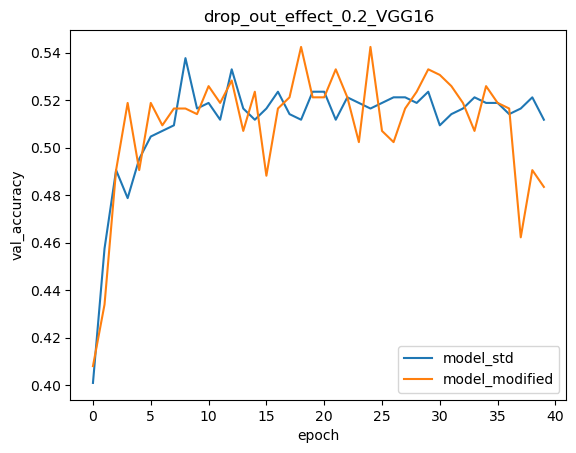

Epoch 1/40
77/77 [==============================] - 9s 118ms/step - loss: 2.1512 - accuracy: 0.2798 - val_loss: 1.7315 - val_accuracy: 0.3844
Epoch 2/40
77/77 [==============================] - 9s 115ms/step - loss: 1.3251 - accuracy: 0.5561 - val_loss: 1.5499 - val_accuracy: 0.4481
Epoch 3/40
77/77 [==============================] - 9s 113ms/step - loss: 1.0094 - accuracy: 0.6629 - val_loss: 1.5286 - val_accuracy: 0.4788
Epoch 4/40
77/77 [==============================] - 10s 132ms/step - loss: 0.7691 - accuracy: 0.7473 - val_loss: 1.5805 - val_accuracy: 0.4788
Epoch 5/40
77/77 [==============================] - 9s 116ms/step - loss: 0.6001 - accuracy: 0.8070 - val_loss: 1.5823 - val_accuracy: 0.4882
Epoch 6/40
77/77 [==============================] - 8s 109ms/step - loss: 0.4528 - accuracy: 0.8648 - val_loss: 1.5942 - val_accuracy: 0.4882
Epoch 7/40
77/77 [==============================] - 9s 116ms/step - loss: 0.3844 - accuracy: 0.8766 - val_loss: 1.8948 - val_accuracy: 0.4481
Epoch

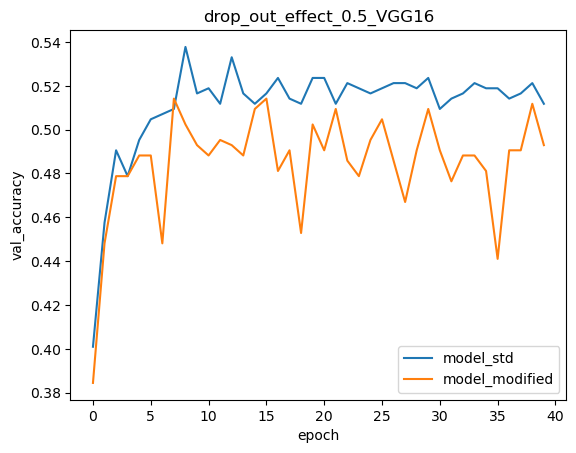

In [21]:
# Je teste 2 valeurs de dropout
value_lst = [0.2, 0.5]

for value in value_lst:
    # Formation du modèle modifié
    model_modified = Sequential()
    model_modified.add(conv_base)
    model_modified.add(Flatten())
    # Ajout du dropout
    model_modified.add(Dropout(value))
    model_modified.add(Dense(256, activation='relu'))
    model_modified.add(Dense(len(train_gen.class_indices), activation='softmax'))
    model_modified.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

    # Mesure des effets de la couche
    history_modified = model_modified.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose)

    title = "drop_out_effect_" + str(value)
    plot_effect(history_std, history_modified, title, subtitle)

### 3-3-4. Mesure de l'effet Fine Tuning
Pour mesurer cela, je dégèle la dernière couche de l'algorithme pour entraînement.

In [9]:
# Avec fine tuning
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
print('Rappel du nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))

conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print('Nombre de poids entraînable après dégel de la dernière couche base convolutionnelle :', len(conv_base.trainable_weights))

# Avec fine tuning
model_modified = get_model(act_function='relu')
model_modified.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history_modified = model_modified.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose)

# Mesure des effets du fine tuning
title = "fine_tuning_effect"
plot_effect(history_std, history_modified, title, subtitle)

Rappel du nombre de poids entraînable avant gel de la base convolutionnelle : 26
Nombre de poids entraînable après dégel de la dernière couche base convolutionnelle : 6
Epoch 1/40
77/77 [==============================] - 9s 121ms/step - loss: 2.5061 - accuracy: 0.0797 - val_loss: 2.4851 - val_accuracy: 0.0731
Epoch 2/40
77/77 [==============================] - 9s 119ms/step - loss: 2.4845 - accuracy: 0.0921 - val_loss: 2.4856 - val_accuracy: 0.0731
Epoch 3/40
77/77 [==============================] - 10s 124ms/step - loss: 2.4840 - accuracy: 0.0921 - val_loss: 2.4858 - val_accuracy: 0.0896
Epoch 4/40
77/77 [==============================] - 9s 123ms/step - loss: 2.4836 - accuracy: 0.0968 - val_loss: 2.4863 - val_accuracy: 0.0896
Epoch 5/40
77/77 [==============================] - ETA: 0s - loss: 2.4835 - accuracy: 0.0968

KeyboardInterrupt: 

### 3-3-5. Conclusion sur les différentes mesures
* La data augmentation augmente les performance du modèle mais le rend légèrement moins stable
* Batch normalization dégrade le modèle
* Dropout avec une valeur de 0.2 maintient le modèle, mais diminue sa stabilité, Dropout avec une valeur de 0.5 dégrade le modèle et le rend instable.
* Contre mon attente, le fine tuning dégrade fortement le modèle, peut-être il y a un problème ?

## 3-4. Evaluation

In [10]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
print('Nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))
conv_base.trainable = False
print('Nombre de poids entraînable après gel de la base convolutionnelle :', len(conv_base.trainable_weights))

model_final = Sequential()
model_final.add(conv_base)
model_final.add(Flatten())
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(len(train_gen_data_aug.class_indices), activation='softmax'))

# Résumé du modèle
model_final.summary()

Nombre de poids entraînable avant gel de la base convolutionnelle : 26
Nombre de poids entraînable après gel de la base convolutionnelle : 0
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 12)                3084      
Total params: 16,815,180
Trainable params: 2,100,492
Non-trainable params: 14,714,688
_________________________________________________________________


----

Epoch 1/500
77/77 [==============================] - 19s 240ms/step - loss: 2.3428 - accuracy: 0.2161 - val_loss: 1.9221 - val_accuracy: 0.3396
Epoch 2/500
77/77 [==============================] - 20s 261ms/step - loss: 1.8318 - accuracy: 0.3766 - val_loss: 1.7365 - val_accuracy: 0.3868
Epoch 3/500
77/77 [==============================] - 19s 243ms/step - loss: 1.6660 - accuracy: 0.4174 - val_loss: 1.6317 - val_accuracy: 0.4387
Epoch 4/500
77/77 [==============================] - 19s 245ms/step - loss: 1.5395 - accuracy: 0.4705 - val_loss: 1.5611 - val_accuracy: 0.4623
Epoch 5/500
77/77 [==============================] - 18s 240ms/step - loss: 1.4495 - accuracy: 0.5207 - val_loss: 1.5164 - val_accuracy: 0.4764
Epoch 6/500
77/77 [==============================] - 19s 253ms/step - loss: 1.3976 - accuracy: 0.5047 - val_loss: 1.5190 - val_accuracy: 0.4882
Epoch 7/500
77/77 [==============================] - 19s 246ms/step - loss: 1.3471 - accuracy: 0.5366 - val_loss: 1.4945 - val_accuracy:

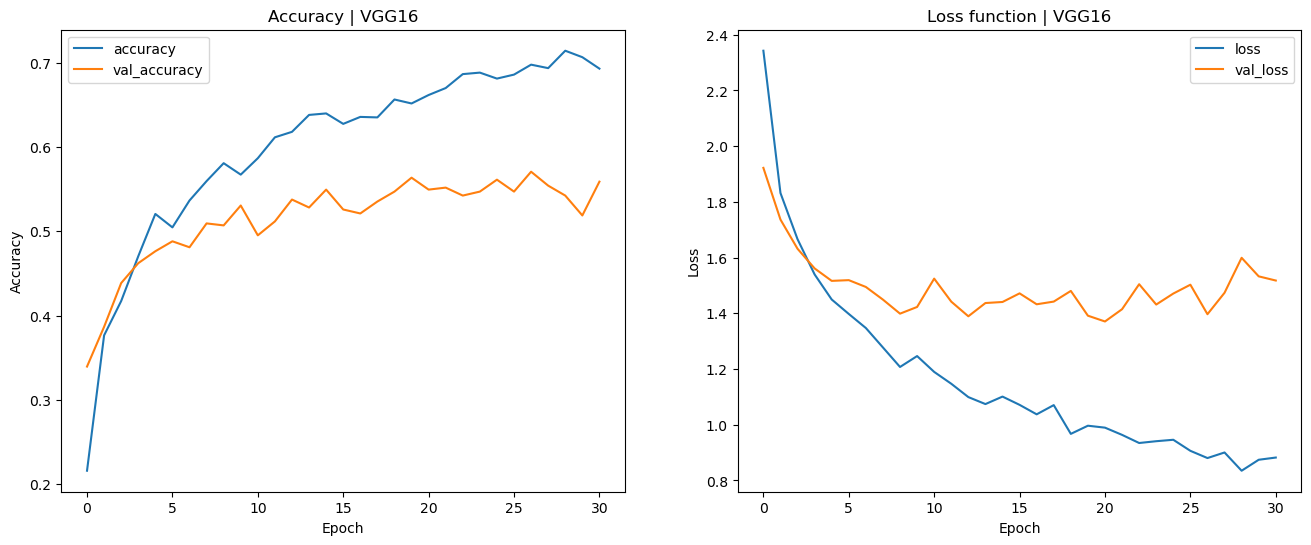

In [11]:
model_final.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=10)
model_save = ModelCheckpoint('best_model_' + subtitle + '.hdf5', save_best_only=True)

history = model_final.fit(train_gen_data_aug, validation_data=val_gen, epochs=500, callbacks = [early_stopping_monitor, model_save])

plot_result_fitting(history, subtitle, n_breeds)

In [12]:
model_final.evaluate(test_gen)

53/53 [==============================] - 3s 56ms/step - loss: 1.4150 - accuracy: 0.5717


[1.4149671792984009, 0.5716981291770935]

# 4. Evaluation du modèle avec 60 races (50 %)

In [19]:
n_breeds = 120
# Création du dataframe avec 50 races
dogs = get_dataframe('../input/stanford-dogs-dataset/images', n_breeds)
print(f"Nous avons {dogs.breeds.nunique()} races sélectionnées pour la montée en charge.")

# Séparation des données d'entrainements et de tests
train, test = train_test_split(dogs, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

### Paramétrage
x = 'uri'
y = 'breeds'
target_size = (150, 150)
seed = 42

train_batch_size = get_batch_size(len(train))
val_batch_size = get_batch_size(len(val))
test_batch_size = get_batch_size(len(test))

train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Avec augmentation des données
train_gen_data_aug = train_datagen_aug.flow_from_dataframe(
                          train,
                          x_col='uri',
                          y_col='breeds',
                          target_size=target_size,
                          batch_size=train_batch_size,
                          seed=seed
                          )

val_gen = val_test_datagen.flow_from_dataframe(
                  val,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=val_batch_size,
                  seed=seed
                  )

test_gen = val_test_datagen.flow_from_dataframe(
                  test,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=test_batch_size,
                  seed=seed,
                  shuffle=False
                  )

Nous avons 120 races sélectionnées pour la montée en charge.
Found 13171 validated image filenames belonging to 120 classes.
Found 3293 validated image filenames belonging to 120 classes.
Found 4116 validated image filenames belonging to 120 classes.


In [21]:
model_final.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_15 (Dense)             (None, 12)                3084      
Total params: 16,815,180
Trainable params: 2,100,492
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
print('Nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))
conv_base.trainable = False
print('Nombre de poids entraînable après gel de la base convolutionnelle :', len(conv_base.trainable_weights))

model_final = Sequential()
model_final.add(conv_base)
model_final.add(Flatten())
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(len(train_gen_data_aug.class_indices), activation='softmax'))

model_final.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=10)
model_save = ModelCheckpoint('best_model_' + subtitle + '.hdf5', save_best_only=True)

history = model_final.fit(train_gen_data_aug, validation_data=val_gen, epochs=500, callbacks = [early_stopping_monitor, model_save])

plot_result_fitting(history, subtitle, n_breeds)

Nombre de poids entraînable avant gel de la base convolutionnelle : 26
Nombre de poids entraînable après gel de la base convolutionnelle : 0
Epoch 1/500


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[1,12] labels_size=[1,120]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at <ipython-input-20-b5c2e7189283>:19) ]] [Op:__inference_train_function_36505]

Function call stack:
train_function


In [ ]:
model_final.evaluate(test_gen)